#### dcd_ch4_hw

# Homework for Chapter 4


In [16]:
#from math import exp
import matplotlib.pyplot as plt
import numpy as np
from PSP_heat_Cole import *
from PSP_thermalCond import *
from PSP_soil import *
from math import *
from PSP_heatSoil import*
from __future__ import division
from PSP_readDataFile import *
from PSP_grid import *
from PSP_ThomasAlgorithm import *

## Problem 1

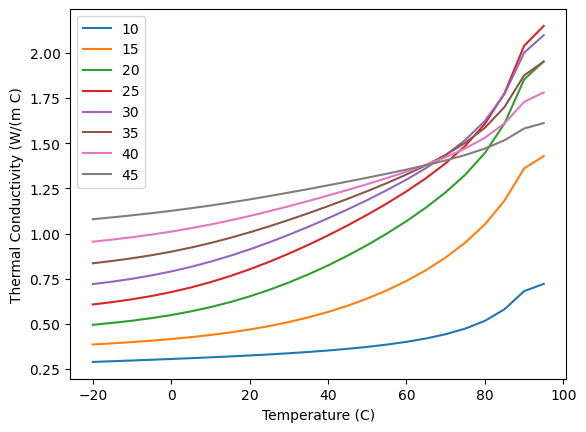

In [17]:
bulkDensity=1300
waterContent=range(10,50,5)
clay=.4
temperature = range(-20,100,5)
ypoints = []
theta_points = []
for y in waterContent:
    ypoints.append(y)
    xpoints =[]
    K_therm = []
    for x in temperature:
        K= thermalConductivity(bulkDensity, y/100 , clay, x)
        xpoints.append(x)
        K_therm.append(K)
    plt.plot(xpoints,K_therm,label = str(y))
plt.xlabel('Temperature (C)')
plt.ylabel('Thermal Conductivity (W/(m C)')
plt.legend((ypoints))

**At what temp is the K of wet soil independent of water content? Why?**

Through the investigation I conducted it would appear that for a wet soil that was 40% clay with a bulk density of $1.3 g cm^{-3}$ that the themal conductivity (K) becomes independent of water content around 70 &deg;C as that is where the differnt plots of K by water content begin to merge or at the very least cross. I believe this is caused by the laws used in the justification of the 1994 Campbell model. This model is based on the idea that the thermal conductivity of the soil is a weighted average of its constiiuent parts. So when the soil gets to roughly 70 &deg;C the conductivity of the soil gas, which is temperature dependent, becomes equivelent to or greater than the thermal conductivity of the soil water.

## Problem 2

In [18]:
theta=range(10,50,5)
bulk=range(1000,1500,50)
C_h = []
for x in bulk:
    for y in theta:
        C = heatCapacity(x,y/100)
        C_h.append(C)
max_C = max(C_h)/(10**6)
min_C = min(C_h)/(10**6)
print('maximum', max_C)
print('minimum', min_C)

maximum 3.1942075471698113
minimum 1.3236603773584905


**What is ths possible range of the specific heat in soil** (had 2 and 4 done but it deleted me back to this checkpiont so thats fun haha)

Since themal diffusivity is considered the conductivity over the specific heat the numerical range for specific heat could be any positive value. However the realistic answer would be that soils will only exhibit a volumetric heat capacity rougly between air ($0.00013 MJ m^{-3} K^{-1}$ ) and Water ($4.18 MJ m^{-3} K^{-1}$) with an average value close to that of mineral soils ($2.31 MJ m^{-3} K^{-1}$). We can simulate this further though with the help of the computer program above and find that a lower bound of $1.3 MJ m^{-3} K^{-1}$ and upper bound of $3.2 MJ m^{-3} K^{-1}$ are reasonable estimations of the volumetric heat capacitys for soils. 

$$ 1.3 MJ m^{-3} K^{-1} < C_h < 3.2 MJ m^{-3} K^{-1} $$

note: tried to call the actuall value using this syntax but I believe it does not support putting numbers in the text via this method 

$$ {{ max_C[0] }}$$

# Problem 3 
**predict temp as a function of time and depth**


In [ ]:
#print (FIN_DIFF, 'Finite Difference')
#print (CELL_CENT_FIN_VOL, 'Cell-Centered Finite Volume')


solver = 1 #int(input("Select solver: "))         ############################
thetaIni = 0.10# "water content (m^3/m^3): "      #############################
meanT = 20 #"mean temperature [C]: "              ###############################
ampT = 1 #"amplitude of change in temperature [C]: " #########################


omega = 2.0 * np.pi/(24 * 3600.0)
airT0 = meanT
timeShift = 8                       

if (solver == FIN_DIFF):
    factor = 0 #"weighting factor for time discretization:" " (0: explicit, 1: implicit Euler) = " 

z = initialize(airT0, thetaIni, solver)
simulationLenght = 70# "nr of simulation hours: "   #############################################
                
endTime = simulationLenght * 3600.0         
timeStepMax = 3600.0                        
dt = timeStepMax / 8.0                      
time = 0.0                                  
sumHeatFlux = 0
totalIterationNr = 0

f, plot = plt.subplots(3, figsize=(8,8), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plot[1].set_xlabel("Time [h]",fontsize=14,labelpad=2)  
plot[1].set_ylabel("Temperature [C]",fontsize=14,labelpad=4)
plot[2].set_xlabel("Time [h]",fontsize=14,labelpad=2)
plot[2].set_ylabel("Heat flux [W m$^{-2}$]",fontsize=14,labelpad=4)
plot[1].set_xlim(timeShift, simulationLenght+timeShift)
plot[1].set_ylim(meanT-ampT, meanT+ampT)
plot[2].set_xlim(timeShift, simulationLenght+timeShift)

#Define output file
file_name = "output_cole.csv"
if os.path.isfile(file_name):
    os.remove(file_name)
    
outFile= open(file_name,"a")
#Write header with depth
outFile.write("time [hr], 0.0 [m], 0.1 [m], 0.3 [m]\n")    

while (time < endTime):
    dt = min(dt, endTime - time)
    airT = airT0 + ampT * np.sin((time+dt)*omega)
    if (solver == FIN_DIFF):
        success, nrIterations, heatFlux = (
            finiteDifference(airT, meanT, dt, factor))            
    elif (solver == CELL_CENT_FIN_VOL):
        success, nrIterations, heatFlux = (
            cellCentFiniteVol(airT, meanT, dt))
    totalIterationNr += nrIterations
    
    
    if success:
        #Convergence achieved
        for i in range(n+1):
            oldT[i] = T[i]
        sumHeatFlux += heatFlux * dt 
        time += dt
        
        t = time/3600. + timeShift
        
        plot[0].clear()
        plot[0].set_xlabel("Temperature [C]",fontsize=14,labelpad=2)
        plot[0].set_ylabel("Depth [m]",fontsize=14,labelpad=4) 
        plot[0].set_xlim(meanT-ampT, meanT+ampT) 
        plot[0].plot(T[1:len(T)], -z[1:len(T)], 'k')
        plot[0].plot(T[1:len(T)], -z[1:len(T)], 'ko')
        plot[1].plot(t, T[getLayerIndex(z, 0.0)], 'ko')    
        plot[1].plot(t, T[getLayerIndex(z, 0.1)], 'ks')     
        plot[1].plot(t, T[getLayerIndex(z, 0.3)], 'k^')    
        plot[2].plot(t, heatFlux, 'ko')
        plt.pause(0.0001)
        #increment time step when system is converging
        if (float(nrIterations/maxNrIterations) < 0.25): 
                dt = min(dt*2, timeStepMax)
        #print(heat.T[getLayerIndex(heat.z, 0.15)])
        #save to file, the number after z is the selected depth        
        outFile.write("%.3f,%.3f,%.3f,%.3f,\n" %(t,T[getLayerIndex(z, 0.0)],T[getLayerIndex(z, 0.1)],T[getLayerIndex(z, 0.3)]))


   #else:
        #No convergence
        #dt = max(dt / 2, 1)
       # for i in range(n+1): T[i] = oldT[i]
        #print ("dt =", dt, "No convergence")

outFile.close()
print("nr of iterations per hour:", totalIterationNr / simulationLenght)
#plt.ioff()
plt.show()
print('done')

**how would residue effect soil temp**

the effect could change many factors relating to the soils thermal properties. If the mulch were of a darker color this could increase absorbition of more direct light causing an incresed amplatude of the surface waveform due to rapid heating. The opposite could be said of lighter reseidue considering an increase in albedo. Also, considering the Volumetric heat capacity of OM is higher than the soil minerals a high OM peat moss mulch would likely need more energy to increase in temperature than it had previously.

**at what depth is the sine wave 180 degrees out of phase with the surface** (trough peak overlap)


I dont know because I cant get this program to work properly and have given in to its continual beat down of my abilities (haha). However judging off of Figure 4.6 I would believe that it occurs closer to the 15 cm depth, possibly around 10 cm if I was to estimate the value.

# Problem 4 
**make PSP_heat change water content with depth**

# Problem 5
**print temp at 15 and 30 cm**

after working on this for close to an hour I got it woking but have come to the realization that this does not calculate for a depth component. Did the authors mean "main 2" and if so that should be an edit explored. that said I cant get anything from main 2 and if I could the question doesnt specify at what time it would want the temp for the simulation. the numbers output at the bottom are in relation to the created graph though and come from the recorded soil temperatures at the 10cm and 25 cm depths.

Temperatures =  [20.3, 20.4, 19.8, 18.0]


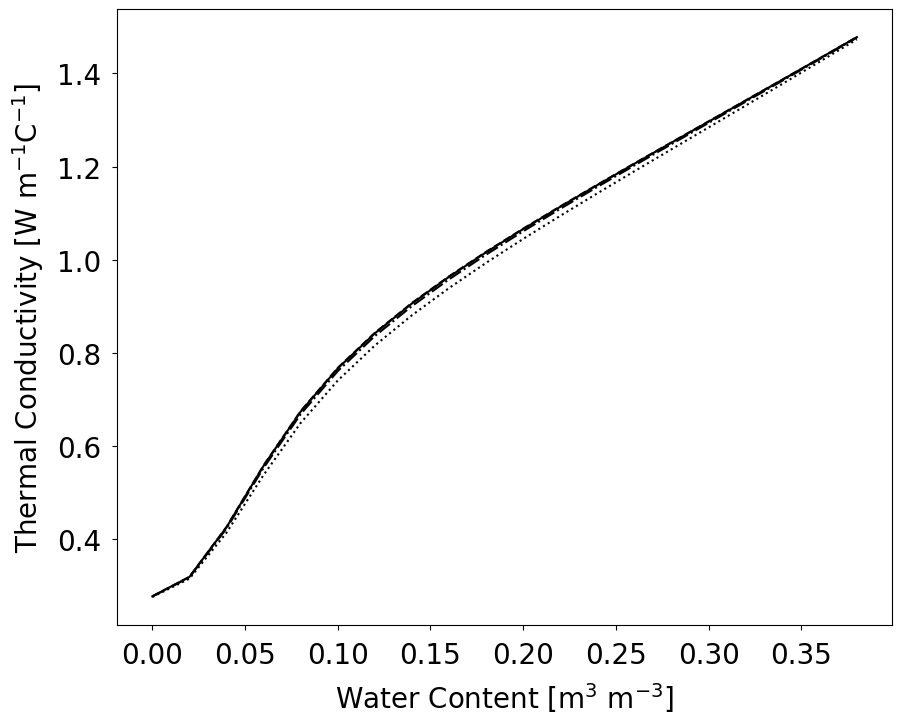

soil temp at 10 cm 20.3
soil temp at 25 cm 20.4


In [19]:
bulkDensity = 1600 # "bulk density [kg/m^3]: "
clay = 0.0 # "clay [0 - 1]: "

A, isFileOk = readDataFile("soilTemperatures_hours.csv", 1, ',', False)

soilTemperature = [A[0][1],A[0][2],A[0][3],A[0][4]] #10 25 70 135 cm
print ("Temperatures = ", soilTemperature)
nrTemperatures = len(soilTemperature)

particleDensity = 2650
porosity = 1 - (bulkDensity / particleDensity) 

step = 0.02  
nrValues = int(porosity / step) + 1
waterContent = np.zeros(nrValues)
thermalConductivitys = np.zeros(nrValues)  ###########after an hour. rename this as it is the name of the command as well
for i in range(nrValues):
    waterContent[i] = step*i


fig = plt.figure(figsize=(10,8))
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]',fontsize=20,labelpad=8)
plt.ylabel('Thermal Conductivity [W m$^{-1}$C$^{-1}$]',fontsize=20,labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
#plt.xlim(0, 0.7)
for t in range(nrTemperatures):
    for i in range(nrValues):
        thermalConductivitys[i] = thermalConductivity(bulkDensity, waterContent[i], clay, soilTemperature[t])
    if (t == 0): plt.plot(waterContent, thermalConductivitys,'k')  
    if (t == 1): plt.plot(waterContent, thermalConductivitys,'--k')   
    if (t == 2): plt.plot(waterContent, thermalConductivitys,'-.k') 
    if (t == 3): plt.plot(waterContent, thermalConductivitys,':k')
plt.show() 
print ('soil temp at 10 cm' , soilTemperature[0])
print ('soil temp at 25 cm' , soilTemperature[1])

# Problem 6

**modify clay and bulk of soil.py and investigate the effect of these variables on soil temp at 3 textures and 2 densiies**

PSP_Soil is all hydraulic based so I believe the author means heatsoil

# Problem 7
**modify PSP Heat investigate the effects of the 3 types of solutions**
